In [1]:
import sys
sys.path.append('..')
import os.path
import copy
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scripts import ab_test, plotting_functions

DATA_DIR = os.path.join('..', 'data')

#Define lab colors
lab_blue = '#2b4888'
lab_pink = '#de4057'
lab_grey = '#de4057'

In [2]:
#Read in files that were generated from Notebook 4
feb_enrolled_baseline = pd.read_csv(os.path.join(DATA_DIR,'Feb_enrolled_at_baseline.csv'),  dtype = {'EMPLID': str})
feb_not_enrolled_baseline = pd.read_csv(os.path.join(DATA_DIR,'Feb_not_enrolled_at_baseline.csv'),  dtype = {'EMPLID': str})

#Read data up until 'newly enrolled' column (we don't need the results)
confirmatory = \
    feb_not_enrolled_baseline.append(feb_enrolled_baseline.iloc[:, : (feb_enrolled_baseline.columns.get_loc('newly_enrolled'))],
                                    sort = True)

feb_enrolled_baseline['treatment_arm'] = np.where((feb_enrolled_baseline.treatment_real == 1) |\
                                                  (feb_enrolled_baseline.treatment_real == 2), 1, 0)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (24,25,29,30,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7,17,19,20,23,28,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Contribution Analysis

In [3]:
# What did contribution amounts in January (baseline) and in February (confirmatory outcomes)? 
pd.merge(pd.DataFrame(feb_enrolled_baseline.FLATAMOUNT_0122.describe()), 
         pd.DataFrame(feb_enrolled_baseline.FLATAMOUNT_0218.describe()),
         left_index = True, right_index = True)

,FLATAMOUNT_0122,FLATAMOUNT_0218
count,13855.000000,13855.000000
mean,188.271231,189.719016
std,271.134244,270.213339
min,0.000000,0.000000
25%,50.000000,50.000000
50%,100.000000,100.000000
75%,200.000000,200.000000
max,5300.000000,6000.000000


In [4]:
# Same as cell above, but in more detail (i.e. look at it via decile)
pd.merge(pd.DataFrame(feb_enrolled_baseline.FLATAMOUNT_0122.describe(percentiles=np.arange(0.1, 1, .1))),
         pd.DataFrame(feb_enrolled_baseline.FLATAMOUNT_0218.describe(percentiles=np.arange(0.1, 1, .1))),
         left_index = True, right_index = True)

,FLATAMOUNT_0122,FLATAMOUNT_0218
count,13855.000000,13855.000000
mean,188.271231,189.719016
std,271.134244,270.213339
min,0.000000,0.000000
10%,20.000000,20.000000
20%,30.000000,30.000000
30.0%,50.000000,50.000000
40%,75.000000,75.000000
50%,100.000000,100.000000
60%,125.000000,125.000000


# How much did people change their savings?

In [5]:
#Calculate the annual increase amounts and the per paycheck increase amounts
feb_enrolled_baseline['annual_increase_amt'] = \
    (feb_enrolled_baseline.ANNUAL_FLAT_AMT_0218 - feb_enrolled_baseline.ANNUAL_FLAT_AMT_0122).astype(int)

feb_enrolled_baseline['per_paycheck_increase'] = \
    (feb_enrolled_baseline.FLATAMOUNT_0218 - feb_enrolled_baseline.FLATAMOUNT_0122).astype(int)

#Filter to only look at positive increases (there were a number of employees who decreased their savings)
positives = feb_enrolled_baseline[(feb_enrolled_baseline.per_paycheck_increase > 0) & 
                                  (feb_enrolled_baseline.annual_increase_amt > 0)]

positives.per_paycheck_increase.describe()

count     505.000000
mean      110.938614
std       229.228966
min         1.000000
25%        27.000000
50%        50.000000
75%       100.000000
max      3083.000000
Name: per_paycheck_increase, dtype: float64

In [6]:
# Increases broken out by treatment conditions (control = 0, treatment = 1)
positives.groupby('treatment_arm')['per_paycheck_increase'].describe(percentiles = np.arange(.1,1,.1)).T

treatment_arm,0,1
count,139.000000,366.000000
mean,117.669065,108.382514
std,284.345814,204.850794
min,5.000000,1.000000
10%,20.000000,20.000000
20%,25.000000,25.000000
30.0%,35.000000,40.000000
40%,50.000000,50.000000
50%,50.000000,50.000000
60%,60.000000,76.000000


In [7]:
# It looks like the average increase in contributions are higher in the control group than the treatment
# Are they statistically significant? 
stats.ttest_ind(positives[positives.treatment_arm == 0]['per_paycheck_increase'],
                positives[positives.treatment_arm == 1]['per_paycheck_increase'])

Ttest_indResult(statistic=0.40628162645950033, pvalue=0.68470847537570945)

### Annual Flat Amounts

Here, we wanted to see if there was any movement out of an employee's initial decile of savings. This analysis did not make it into the report, but we are keeping it here because it's mildly interesting!

While more ppl incr contrib in treat group over control, people did not make large change in their contributions so the quantiles didn't change much. 
People's contribution decisions (amount) can be affected by many things other than email.
- where they are in their lives financially, married w/ dual income

But whether they contribute appear to be impacted by the email
 - we trigger that by sending out an email
 

In [8]:
'''
Use qcut to break our data up into deciles and return the decile they belong to. Equivalent to:
np.where(feb_enrolled_baseline['ANNUAL_FLAT_AMT_0122'] <= np.percentile(feb_enrolled_baseline['ANNUAL_FLAT_AMT_0122'], 10), 
             10, 
np.where(feb_enrolled_baseline['ANNUAL_FLAT_AMT_0122'] <= np.percentile(feb_enrolled_baseline['ANNUAL_FLAT_AMT_0122'], 20),
             20, 
etc
'''

feb_enrolled_baseline['percentile_0122'] = pd.qcut(feb_enrolled_baseline['ANNUAL_FLAT_AMT_0122'], 
                                                   10, 
                                                   labels = np.arange(10,110,10))


feb_enrolled_baseline['percentile_0218'] = pd.qcut(feb_enrolled_baseline['ANNUAL_FLAT_AMT_0218'], 
                                                   10, 
                                                   labels = np.arange(10,110,10))

#Break data up into treatment and control
control_ann = feb_enrolled_baseline[feb_enrolled_baseline.treatment_real == 0]

treatment_ann = \
 feb_enrolled_baseline[(feb_enrolled_baseline.treatment_real == 1)|(feb_enrolled_baseline.treatment_real == 2)]

In [9]:
#For the treatment group, the percentage of the population that stayed in their percentile of savings or moved across percentiles
print('Treatment')
round((pd.crosstab(treatment_ann.percentile_0122, treatment_ann.percentile_0218, margins = True, normalize='index')*100),2)

Treatment


percentile_0218,10,20,30,40,50,60,70,80,90,100
percentile_0122,,,,,,,,,,
10,97.56,0.18,0.81,0.09,0.45,0.00,0.45,0.00,0.09,0.36
20,0.26,97.39,1.04,0.52,0.39,0.13,0.13,0.00,0.13,0.00
30,0.20,0.20,96.93,0.65,1.30,0.00,0.39,0.13,0.20,0.00
40,0.00,0.00,0.18,97.46,1.63,0.54,0.18,0.00,0.00,0.00
50,0.28,0.00,0.35,0.00,95.96,0.21,2.09,0.28,0.77,0.07
60,0.41,0.82,0.00,0.00,0.00,93.03,5.74,0.00,0.00,0.00
70,0.29,0.07,0.29,0.07,0.22,0.07,95.81,1.62,1.40,0.15
80,0.49,0.00,0.00,0.00,0.24,0.00,0.24,93.89,4.65,0.49
90,0.31,0.00,0.00,0.10,0.62,0.00,0.62,3.38,93.54,1.44


In [10]:
#For the control group, the percentage of the population that stayed in their percentile of savings or moved across percentiles 
print('Control')
round((pd.crosstab(control_ann.percentile_0122, control_ann.percentile_0218,  margins = True, normalize='index')*100),2)

Control


percentile_0218,10,20,30,40,50,60,70,80,90,100
percentile_0122,,,,,,,,,,
10,97.45,0.18,0.55,0.18,0.73,0.00,0.18,0.18,0.18,0.36
20,0.00,98.22,1.27,0.25,0.00,0.00,0.25,0.00,0.00,0.00
30,0.40,0.00,97.32,0.67,1.07,0.00,0.27,0.27,0.00,0.00
40,0.36,0.36,0.00,97.84,1.44,0.00,0.00,0.00,0.00,0.00
50,0.14,0.00,0.27,0.00,96.99,0.68,1.37,0.14,0.27,0.14
60,0.00,0.00,0.75,0.00,0.00,95.49,3.76,0.00,0.00,0.00
70,0.31,0.00,0.31,0.15,0.46,0.15,96.64,0.76,1.07,0.15
80,0.52,0.52,1.04,0.00,0.00,0.00,0.52,94.79,2.60,0.00
90,0.36,0.00,0.00,0.18,0.18,0.00,0.54,2.17,94.93,1.63


# Exploring Enrollments by Agency

In the discussion section of the report, 

In [11]:
# Set up the data
'''
Pull in DCHR data about active number of employees
I originally used this bc DCHR has their own list about # of active employees; however, 
they don't line up with the total number of employees that we have, so using OCTO data as our baseline number of employees.
But now using this data file since it maps budget codes to agency codes.  
'''

active_employees = pd.read_csv(os.path.join(DATA_DIR, 'num_employees.csv'), encoding='ISO-8859-1')

#Formatting new dataframe
enrollment = confirmatory.groupby(confirmatory.enrolled_0122)['Agency Code'].value_counts().unstack().T.reset_index()\
             .rename(columns = {False: 'Not_Enrolled', True: 'Enrolled'})

#Our total employee columns
enrollment['OCTO_total_emp'] = enrollment.Not_Enrolled + enrollment.Enrolled
enrollment.head()

enrolled_0122,Agency Code,Not_Enrolled,Enrolled,OCTO_total_emp
0,AA,50.0,38.0,88.0
1,AB,68.0,89.0,157.0
2,AC,4.0,26.0,30.0
3,AD,21.0,53.0,74.0
4,AE,10.0,28.0,38.0


In [12]:
#Clean up agency names

#Create a dictionary, so that every agency name is linked to its agency code
# See https://stackoverflow.com/questions/51570364/underscore-in-for-loop for why the underscore is needed
one = {row['Agency Name']: row['Agency Code'] for _, row in confirmatory.iterrows()}

#create a dict, so that the agency code becomes the key, and agency name becomes the value
#This drops the extra agency name so that one agency name is mapped to one agency code
code_to_name = {v: k for k, v in one.items()}

#Map the names
name_to_name = {k: code_to_name[v] for k, v in one.items()}

#Create a column in the df that maps the names in "Agency Name" to the names in name_to_names
confirmatory['agency_name'] = confirmatory['Agency Name'].map(name_to_name)


#Merge active employee data to our data
enrollment = (pd.merge(enrollment, 
                       active_employees[['Agency.ID', 'Agency.Abbreviation', 'FY18', 'FY19']], 
                       how = 'left', 
                       left_on = 'Agency Code', 
                       right_on='Agency.ID'))\
            .merge(confirmatory[['Agency Code', 'agency_name']].drop_duplicates(), 
                   how = 'left', 
                   left_on = 'Agency Code', 
                   right_on='Agency Code')

#Get proportions of not-enrolled employees and enrolled employees using OCTO data as baseline
enrollment['not_enr_proportion_OCTO'] = enrollment.Not_Enrolled/enrollment.OCTO_total_emp
#Enrolled
enrollment['enr_proportion_OCTO'] = enrollment.Enrolled/enrollment.OCTO_total_emp

#Add up total percentage (=1) for plotting purposes
enrollment['total_pct'] = enrollment['not_enr_proportion_OCTO'] + enrollment['enr_proportion_OCTO']
enrollment.sort_values(by = 'not_enr_proportion_OCTO', inplace = True)

In [13]:
print('Quantile : Number of Employees')
for i in np.arange(0, 1.1, .1):
    print('    ', i, ':', round(enrollment.OCTO_total_emp.quantile(i)))

Quantile : Number of Employees
     0.0 : 2
     0.1 : 7
     0.2 : 12
     0.3 : 18
     0.4 : 35
     0.5 : 59
     0.6 : 89
     0.7 : 199
     0.8 : 480
     0.9 : 918
     1.0 : 7997


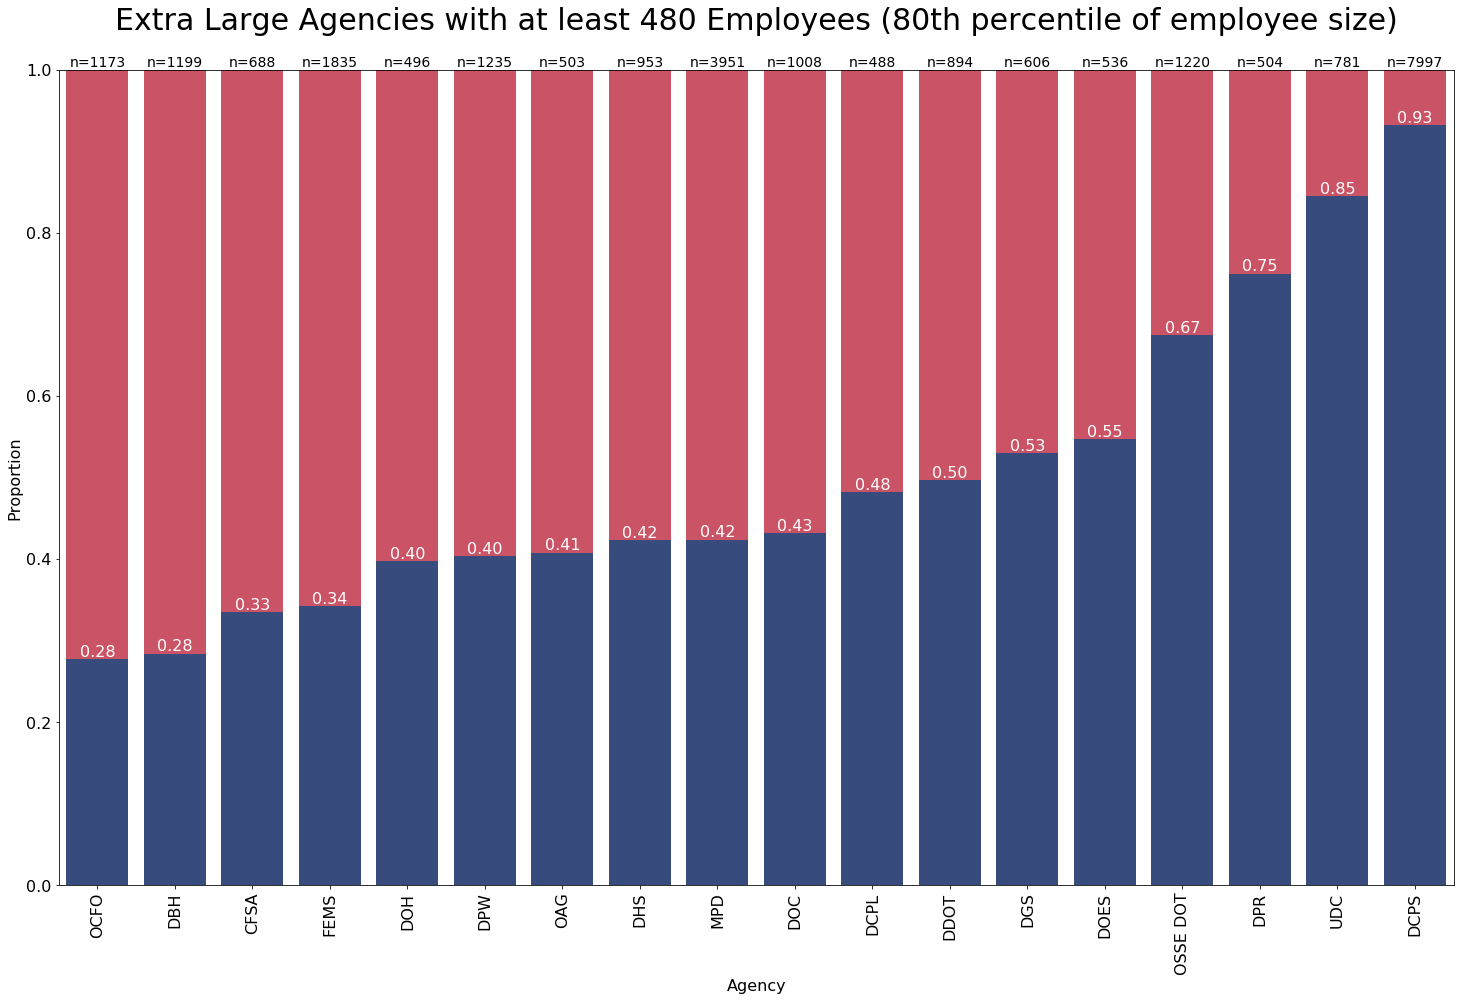

In [14]:
xlarge = enrollment[enrollment.OCTO_total_emp >= round(enrollment.OCTO_total_emp.quantile(.80))]

plt.figure(figsize=(25,15))
sns.barplot(x = 'Agency.Abbreviation', y = 'total_pct', 
            data = xlarge, color = '#de4057')
sns.barplot(x = 'Agency.Abbreviation', y = 'not_enr_proportion_OCTO', 
            data = xlarge, color = '#2b4888')

plt.ylim(0,1)
plt.tick_params(axis = 'both', labelsize = 16)
plt.xticks(rotation = 90)
plt.ylabel('Proportion', fontsize = 16)
plt.xlabel('Agency', fontsize = 16)
plt.title('Extra Large Agencies with at least 480 Employees (80th percentile of employee size)', 
          fontsize = 30, pad = 40)

plotting_functions.showProportionLabels(xlarge)


plt.show()

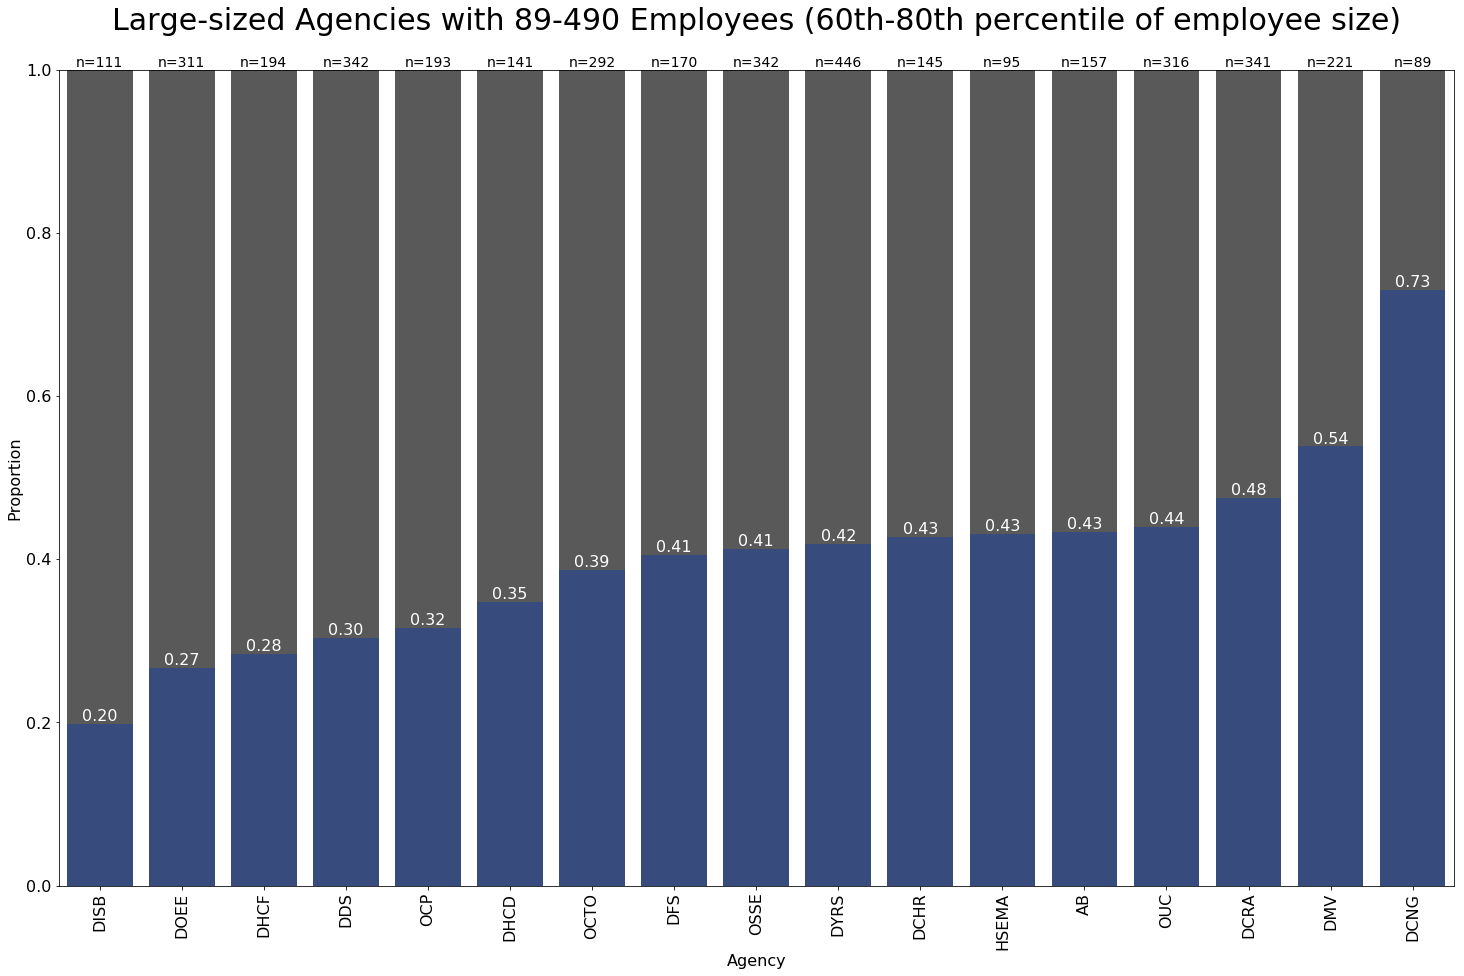

In [15]:
large = enrollment[(enrollment.OCTO_total_emp >= round(enrollment.OCTO_total_emp.quantile(.60))) & \
                   (enrollment.OCTO_total_emp < round(enrollment.OCTO_total_emp.quantile(.80)))]

plt.figure(figsize=(25,15))
sns.barplot(x = 'Agency.Abbreviation', y = 'total_pct', 
            data = large, color = '#595959')
sns.barplot(x = 'Agency.Abbreviation', y = 'not_enr_proportion_OCTO', 
            data = large, color = '#2b4888')

plt.ylim(0,1)
plt.tick_params(axis = 'both', labelsize = 16)
plt.xticks(rotation = 90)
plt.ylabel('Proportion', fontsize = 16)
plt.xlabel('Agency', fontsize = 16)
plt.title('Large-sized Agencies with 89-490 Employees (60th-80th percentile of employee size)', fontsize = 30, pad = 40)

plotting_functions.showProportionLabels(large)

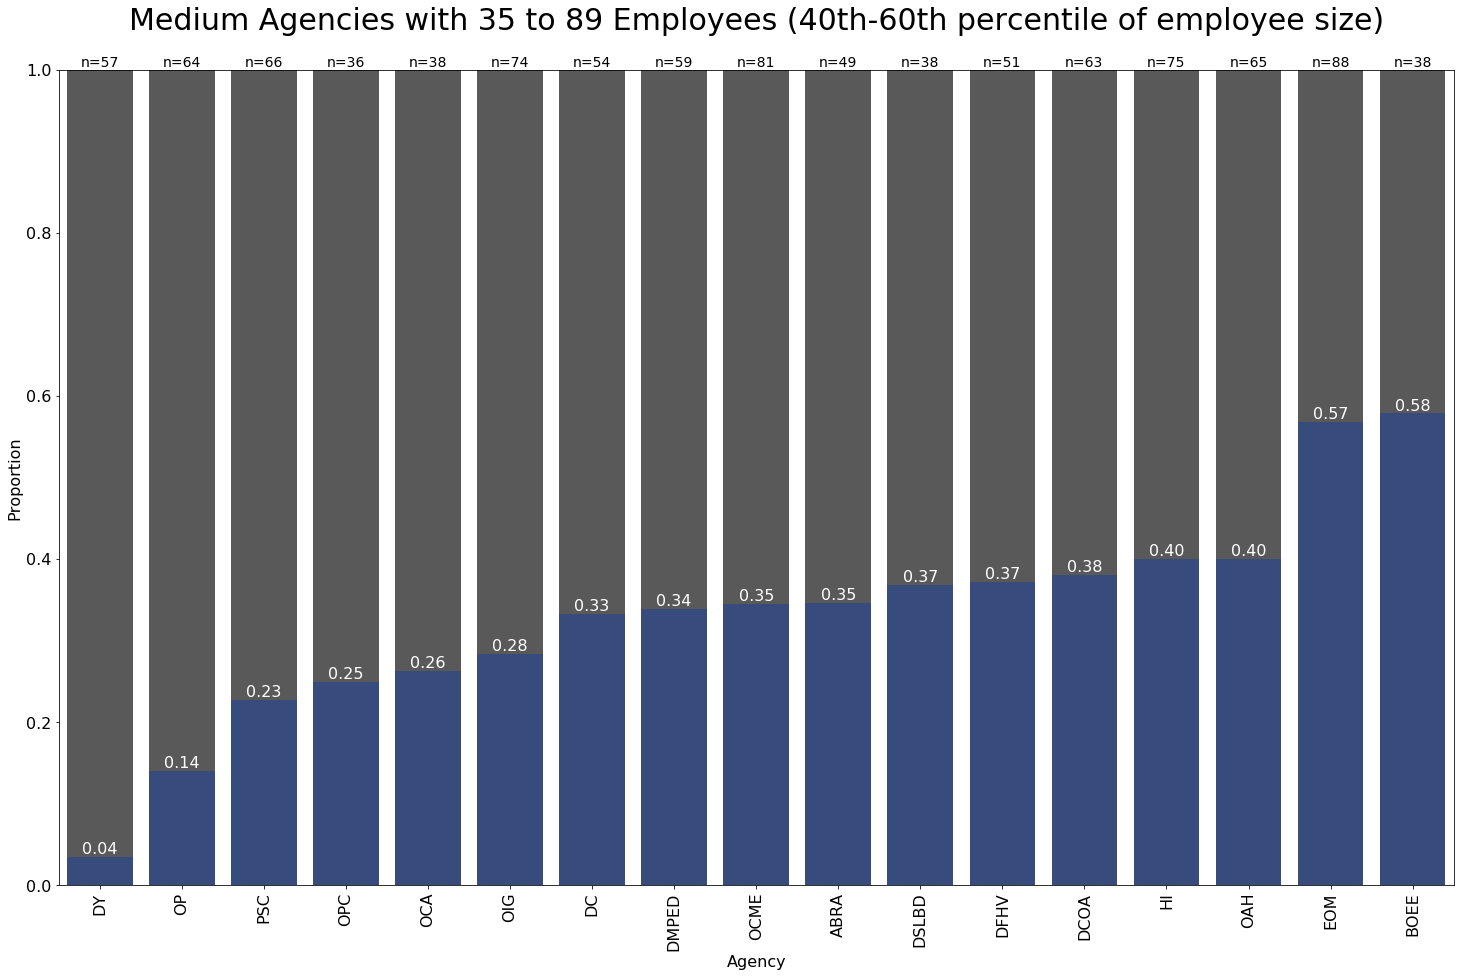

In [16]:
medium = enrollment[(enrollment.OCTO_total_emp >= round(enrollment.OCTO_total_emp.quantile(.40))) & \
                   (enrollment.OCTO_total_emp < round(enrollment.OCTO_total_emp.quantile(.60)))]

plt.figure(figsize=(25,15))
sns.barplot(x = 'Agency.Abbreviation', y = 'total_pct', 
            data = medium, color = '#595959')
sns.barplot(x = 'Agency.Abbreviation', y = 'not_enr_proportion_OCTO', 
            data = medium, color = '#2b4888')

plt.ylim(0,1)
plt.tick_params(axis = 'both', labelsize = 16)
plt.xticks(rotation = 90)
plt.ylabel('Proportion', fontsize = 16)
plt.xlabel('Agency', fontsize = 16)
plt.title('Medium Agencies with 35 to 89 Employees (40th-60th percentile of employee size)', fontsize = 30, pad = 40)

plotting_functions.showProportionLabels(medium)


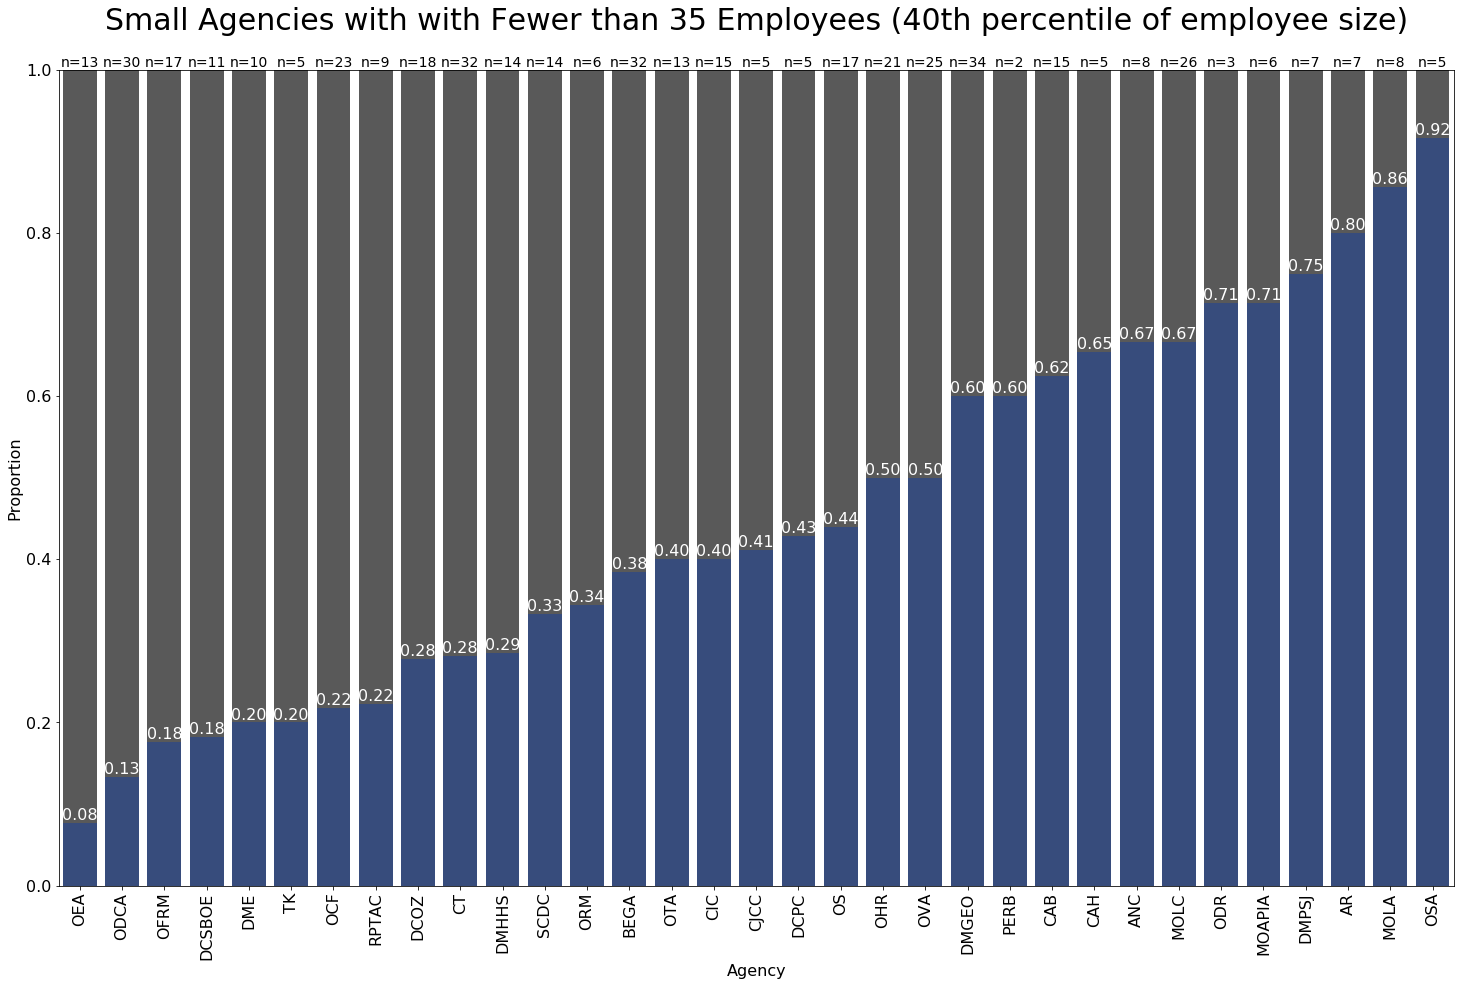

In [17]:
small = enrollment[enrollment.OCTO_total_emp < round(enrollment.OCTO_total_emp.quantile(.40))]

plt.figure(figsize=(25,15))
sns.barplot(x = 'Agency.Abbreviation', y = 'total_pct', 
            data = small, color = '#595959')
sns.barplot(x = 'Agency.Abbreviation', y = 'not_enr_proportion_OCTO', 
            data = small, color = '#2b4888')

plt.ylim(0,1)
plt.tick_params(axis = 'both', labelsize = 16)
plt.xticks(rotation = 90)
plt.ylabel('Proportion', fontsize = 16)
plt.xlabel('Agency', fontsize = 16)
plt.title('Small Agencies with with Fewer than 35 Employees (40th percentile of employee size)', fontsize = 30, pad = 40)

plotting_functions.showProportionLabels(small)